In [1]:
from parti_pytorch import VitVQGanVAE, VQGanVAETrainer


import os
import configparser
import pathlib
import shutil
import random
from PIL import Image,ImageFilter

# Loading configurations
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)

insert_amd_env_vars =  int(configParser.get('COMMON', 'insert_amd_env_vars'))
HSA_OVERRIDE_GFX_VERSION =  configParser.get('COMMON', 'HSA_OVERRIDE_GFX_VERSION')
ROCM_PATH =  configParser.get('COMMON', 'ROCM_PATH')


if(insert_amd_env_vars != 0):
    os.environ["HSA_OVERRIDE_GFX_VERSION"] = HSA_OVERRIDE_GFX_VERSION
    os.environ["ROCM_PATH"] = ROCM_PATH


image_size =  int(configParser.get('COMMON', 'resizeImageTo'))
source_dir = configParser.get('extractFaces', 'datasetPathFaces')
base_dir = configParser.get('vae', 'base_dir')
no_images_used = int(configParser.get('vae', 'no_images_used'))
boxBlurMin =  int(configParser.get('vae', 'boxBlurMin'))
boxBlurMax =  int(configParser.get('vae', 'boxBlurMax'))

gaussianBlurMin =  int(configParser.get('vae', 'gaussianBlurMin'))
gaussianBlurMax =  int(configParser.get('vae', 'gaussianBlurMax'))

pix_to_min =  int(configParser.get('vae', 'pix_to_min'))
pix_to_max =  int(configParser.get('vae', 'pix_to_max'))

2023-09-27 13:30:38.246258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 13:30:38.341495: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


i = 0
j = 0
user_prev = ""
for root, dirs, files in os.walk(source_dir):

    if(j > no_images_used):
        break

    for file in files:
        i = i + 1
        p_small = pathlib.Path(os.path.dirname(root + "/" + file))
        p_big = p_small.parent.absolute()
        user = p_big.name
        folderFace = base_dir + "/" + user
        new_file = folderFace + "/" + file
        if(user_prev != user):
            pathlib.Path(os.path.dirname(new_file)).mkdir(parents=True, exist_ok=True)
            #shutil.copy2(root + "/" + file, new_file )
            user_prev = user
            #print(user_prev)
            #print(user)
            
            im = Image.open(root + "/" + file).convert('RGB')

            blurOption = random.randint(1, 6)

            if(blurOption==1):
                imBlurred = im.filter(ImageFilter.BoxBlur(random.randint(boxBlurMin, boxBlurMax))) # 4 to 14
            elif(blurOption==2):
                imBlurred = im.filter(ImageFilter.GaussianBlur(random.randint(gaussianBlurMin, gaussianBlurMax))) # 4 to 8
            elif(blurOption==3):
                imBlurred = im.filter(ImageFilter.BoxBlur(random.randint(int(boxBlurMin/2),int(boxBlurMax/2)))).filter(
                    ImageFilter.GaussianBlur(random.randint(int(gaussianBlurMin/2),int(gaussianBlurMax/2)))) 
            elif(blurOption==4 or blurOption==5 or blurOption==6):
                pix_to = random.randint(int(pix_to_min), int(pix_to_max))
                imBlurred = im.resize((pix_to,pix_to), resample=Image.Resampling.BILINEAR) # 8 to 24
                imBlurred = imBlurred.resize(im.size, Image.Resampling.NEAREST)
                #print('pixalated')
            j = j + 1
            imBlurred.save(new_file)
            imBlurred.close()
            print('image: ' + str(j) + ", " + 'of total images scanned:' + str(i))

        
        
    

In [2]:
vit_vae = VitVQGanVAE(
    dim = 256,               # dimensions
    image_size = image_size,        # target image size
    patch_size = 14,         # size of the patches in the image attending to each other
    num_layers = 3           # number of layers
).cuda()


trainer = VQGanVAETrainer(
    vit_vae,
    folder = base_dir,
    num_train_steps = 601,
    lr = 3e-4,
    batch_size = 4,
    grad_accum_every = 8,
    amp = True,
    results_folder = '/media/gamal/Passport/parti/vae',
    save_results_every = 50,
    save_model_every = 200,
)



/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


5737 training samples found at /media/gamal/Passport/Datasets/VoxCeleb2/Voxceleb2VQVAETrain
training with dataset of 5450 samples and validating with randomly splitted 287 samples


In [3]:
trainer.train()

0: vae loss: 0.7254053726792336 - discr loss: 270.1008243560791
0: saving to /media/gamal/Passport/parti/vae
0: saving model to /media/gamal/Passport/parti/vae
1: vae loss: 0.47909384593367577 - discr loss: 247.72329330444336
2: vae loss: 0.4706922210752964 - discr loss: 246.0895538330078
3: vae loss: 0.4365350380539894 - discr loss: 267.8189296722412
4: vae loss: 0.34996021911501884 - discr loss: 294.4900360107422
5: vae loss: 0.31262799352407455 - discr loss: 250.22281646728516
6: vae loss: 0.2766491137444973 - discr loss: 239.34062004089355
7: vae loss: 0.26184358820319176 - discr loss: 9.476194143295288
8: vae loss: 0.24305975437164307 - discr loss: 10.144468605518341
9: vae loss: 0.22801450081169605 - discr loss: 2.8376286923885345
10: vae loss: 0.22785069607198238 - discr loss: 6.413839042186737
11: vae loss: 0.22966371290385723 - discr loss: 5.6211801171302795
12: vae loss: 0.2111290842294693 - discr loss: 4.64230614900589
13: vae loss: 0.21830890513956547 - discr loss: 3.342204

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 trainer.train()                                                                              │
│   2                                                                                              │
│                                                                                                  │
│ /home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/parti_pytorch/vit_vqgan_trainer. │
│ py:275 in train                                                                                  │
│                                                                                                  │
│   272 │   │   device = next(self.vae.parameters()).device                                        │
│   273 │   │                                                                                      │
│   274 │   │   while self.steps < self.num_train_steps:                                           │
│ ❱ 275 │   │   │   logs = self.train_step()                                                       │
│   276 │   │   │   log_fn(logs)                                                                   │
│   277 │   │                                                                                      │
│   278 │   │   print('training complete')                                                         │
│                                                                                                  │
│ /home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/parti_pytorch/vit_vqgan_trainer. │
│ py:216 in train_step                                                                             │
│                                                                                                  │
│   213 │   │   │   │   with autocast(enabled = self.amp):                                         │
│   214 │   │   │   │   │   loss = self.vae(img, return_discr_loss = True)                         │
│   215 │   │   │   │   │                                                                          │
│ ❱ 216 │   │   │   │   │   self.discr_scaler.scale(loss / self.grad_accum_every).backward()       │
│   217 │   │   │   │                                                                              │
│   218 │   │   │   │   accum_log(logs, {'discr_loss': loss.item() / self.grad_accum_every})       │
│   219                                                                                            │
│                                                                                                  │
│ /home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/torch/_tensor.py:487 in backward │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    489 │   │   )                                                                                 │
│    490                                                                                           │
│                                                                                                  │
│ /home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/torch/autograd/__init__.py:200   │
│ in backward                                                

In [4]:
import torch
model_path =  configParser.get('vae', 'model_name')
state_dict = vit_vae.state_dict()

torch.save(state_dict, model_path)

In [5]:
from torchvision import transforms as T
transform = T.Compose([
            T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
            T.Resize(image_size),
            T.RandomHorizontalFlip(),
            T.CenterCrop(image_size),
            T.ToTensor()
        ])

In [6]:
from PIL import Image
import torch
img = Image.open("a12.png")
images = transform(img)
print(images.shape)

images = torch.unsqueeze(images, 0)
images = images.cuda()

torch.Size([3, 128, 128])


In [7]:
xy=  vit_vae.encode(images, return_indices_and_loss = True)

In [8]:
xy[0].shape

torch.Size([1, 256, 8, 8])

In [9]:
y = vit_vae.decode(xy[0])

In [10]:
y.shape

torch.Size([1, 3, 128, 128])

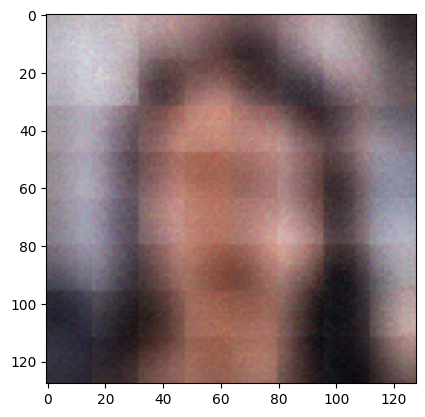

In [11]:
import matplotlib.pyplot as plt
plt.imshow(  y[0].permute(1, 2, 0).cpu().detach().numpy()   )